<a href="https://colab.research.google.com/github/leeoos/airo-neural-networks/blob/main/homeworks/NN_2022_Homework_1799057.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks
## Homework 1: Implementing advanced activation functions

**Name**: *Leonardo Colosi*

**Matricola**: *1799057*

Upload the completed notebook **one week before the exam date of your choice** on the Google Classrom page.

In [ ]:
import torch
import torch.nn as nn

### Objective

The purpose of this homework is to implement a new layer inside PyTorch, by properly extending the `nn.Module` object. **Before proceeding**, carefully read the following documentation:

+ [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=module#torch.nn.Module)
+ [PyTorch: Custom Module](https://pytorch.org/tutorials/beginner/examples_nn/polynomial_module.html)

You can also (optionally) learn more about activation functions by reading the survey in [1].

### Introduction: families of activation functions

In the course up to now, we have seen the application of the sigmoid, the softmax, and the ReLU. However, many additional activation functions exist [1], with varying strengths and drawbacks.

Several of them are designed as variants of the ReLU. The **S-Shaped ReLU** (SReLU) [2] is defined as:

$$
\phi(s) = \begin{cases} t^r + a^r(s - t^r) & \text{ if } s > t^r \\ s & \text{ if } t^r > s > t^l \\ t^l + a^l(s - t^l) & \text{ if } s < t^l \end{cases} \,.
$$

The four parameters $t^r, a^r, t^l, a^l$ are trained via back-propagation, and they are **different for each unit in the layer**.


### Exercise 1: implementing an activation function (1 point)

Let us start with the simpler **[exponential linear squashing](https://paperswithcode.com/method/elish)** (ELiSH) activation function:

$$
\phi(x) = \begin{cases} \sigma(x)x & \text{ if } x \ge 0 \\ \frac{\exp(x) - 1}{1 + \exp(-x)} & \text{ otherwise} \end{cases}
$$

**Exercise 1**: complete the following stub.

In [ ]:
def elish(x):
  # x is a generic torch.Tensor, and this function must compute the ELiSH activation function.
  # raise NotImplementedError # TODO: substitute this with your code

  # Alternative: use torch.sigmioid
  sigmoid = torch.sigmoid(x)
  elish_sig = sigmoid * x
  elish_exp = sigmoid * (torch.exp(x) -1)


  # Build tensor of booleans to check the conndiction
  x_gt_eq_zero = x >= 0

  # ELisH implementation with torch condictional
  output = torch.where(x_gt_eq_zero, elish_sig, elish_exp)

  return output

**Hints for a correct implementation**:

1. There are several ways of implementing an if/else operation like the one above in PyTorch. In general, the simplest implementation of "*if a then b, else c*" is `torch.where(a, b, c)` (see the documentation for [torch.where](https://pytorch.org/docs/stable/generated/torch.where.html)). Any working variant is accepted here.

Here is a simple sanity check for the correct implementation:

In [ ]:
elish(torch.FloatTensor([[0.2, -0.4]])) # Should be approximately [[0.11, -0.13]]

tensor([[ 0.1100, -0.1323]])

### Exercise 2: some visualization experiments (1 point)

**Exercise 2.1**: plot the ELiSH function in [-5, +5].

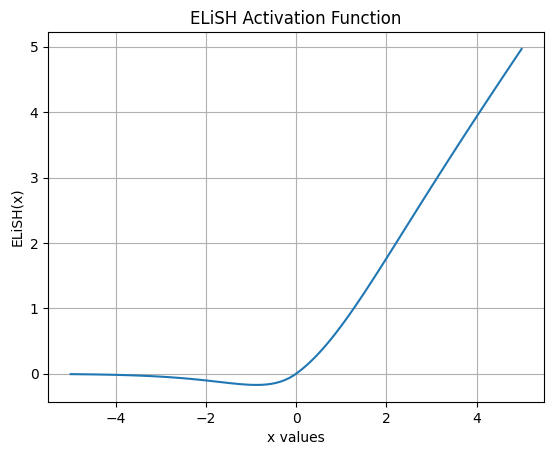

In [ ]:
import matplotlib.pyplot as plt
# TODO: plot the function

# Points interval definition
x = torch.linspace(-5, 5, 100)
y = elish(x)
x.requires_grad = True # enableling gradient tracking for later computation

# Figure definition
plt.title('ELiSH Activation Function')
plt.xlabel('x values')
plt.ylabel('ELiSH(x)')
plt.grid(True)

# Calls to detach and numpy are used to convert the PyTorch tensors to NumPy arrays for plotting.
plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

**Exercise 2.2**: using the utilities from `torch.autograd` ([torch.autograd](https://pytorch.org/docs/stable/autograd.html)), **compute and plot** the derivative of ELiSH using automatic differentiation.

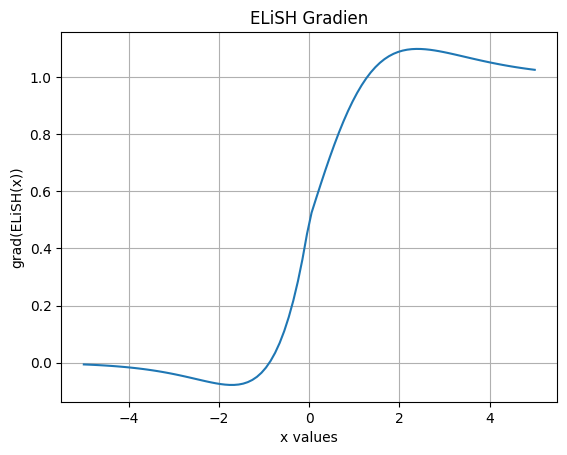

In [ ]:
# TODO: plot the gradient of the ELiSH function

# Since elish(x) return a tesor of the ELiSH activation function values at different x points,
# summing it will reduce it to a scalar value.
y = elish(x).sum()

# Compute gradients with respect to x.
gradient = torch.autograd.grad(y, x)    # returns a tuple of gradients, one for each input.
gradient = gradient[0]  # since we only have one element


# Figure definition
plt.title('ELiSH Gradien')
plt.xlabel('x values')
plt.ylabel('grad(ELiSH(x))')
plt.grid(True)

plt.plot(x.detach().numpy(), gradient.detach().numpy())
plt.show()

**Exercise 2.3 (sanity check)**: build a model using the previously defined activation function, and test it on a random mini-batch of data:

In [ ]:
# TODO: complete the definition of the model

W = torch.rand((10, 1))
B = torch.rand((1, 1))

# Definition of a Perceptron with random weights and ELiSH as activation function
model = lambda X: elish(X@W + B)

print(model(torch.randn((5, 10))))

tensor([[ 0.5764],
        [ 1.8147],
        [ 0.1559],
        [ 1.3818],
        [-0.1194]])


## Exercise 3: implementing a trainable activation function (2 points)

**Exercise 3:** define a `torch.nn.Module` implementing the SReLU.

**Hints for a correct implementation**:
* The layer should **only** implement the activation function. Ideally, it will always be used in combination with a fully-connected layer with no activation function.
* Think carefully about how you want to initialize the parameters.

In [ ]:
class SReLU(nn.Module):
  """
  S-shaped Rectified Linear Unit.
  It follows:
    f(x) = b^r + w^r(x - b^r)   for x >= b^r,
    f(x) = x                    for b^r > x > b^l`,
    f(x) = b^l + w^l(x - b^l)   for x <= b^l.
  """

  def __init__(self, units):
    # raise NotImplementedError # TODO: implement

    # Call super constructor to inherit all the methods and properties from nn.Module:
    super(SReLU, self).__init__()
    self.units = units

    # Weights and Biases initialization for each unit in the layer
    # The biases represent the limits of the interval
    self.b_l = nn.Parameter(torch.zeros(units), requires_grad=True)   # from 0
    self.w_l = nn.Parameter(torch.rand(units), requires_grad=True)
    self.b_r = nn.Parameter(torch.ones(units), requires_grad=True)    # to 1
    self.w_r = nn.Parameter(torch.rand(units), requires_grad=True)

    # Parameters registration
    # self.register_parameter('w_l', self.w_l)
    # self.register_parameter('w_r', self.w_r)
    # self.register_parameter('b_l', self.b_l)
    # self.register_parameter('b_r', self.b_r)

    # self.total_parameters = int(len(self.w_l)) + int(len(self.w_l))
    #                         + int(len(self.b_l)) + int(len(self.b_l))

  def forward(self, inputs):
    # raise NotImplementedError # TODO: implement

    # Set the output to be equal to the input as if b_l < inputs < b_r
    output = inputs

    # If input >= b^r then apply the right part of SReLU otherwise keep the output as it is
    right_input = inputs >= self.b_r
    output = torch.where(right_input, (self.b_r + self.w_r*(inputs - self.b_r)), output)

    # If input <= b^l then apply the left part of SReLU otherwise keep the output as it is
    left_input = inputs <= self.b_l
    output = torch.where(right_input, (self.b_l + self.w_l*(inputs - self.b_l)), output)

    #print(output)

    return output

As a sanity check, initialize a SReLU layer and count the number of parameters:

In [ ]:
# Initialize the layer
layer = SReLU(2)

# Count the parameters
print(sum(_.numel() for _ in layer.parameters())) # Should print 8!

8


## Exercise 4: training a model with trainable activation functions (1 point)

We will use the following dataset from TensorFlow Datasets:
https://www.tensorflow.org/datasets/catalog/german_credit_numeric

In [ ]:
import tensorflow_datasets as tfds
train_data = tfds.load('german_credit_numeric', split='train[:75%]', as_supervised=True)
test_data = tfds.load('german_credit_numeric', split='train[75%:]', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/german_credit_numeric/1.0.0.incompleteYARC8F/german_credit_numeric-train.t…

Dataset german_credit_numeric downloaded and prepared to /root/tensorflow_datasets/german_credit_numeric/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Train set
Xtrain, ytrain = train_data.batch(5000).get_single_element()
Xtrain, ytrain = Xtrain.numpy(), ytrain.numpy()

# Tets set
Xtest, ytest = test_data.batch(5000).get_single_element()
Xtest, ytest = Xtest.numpy(), ytest.numpy()

**Exercise 4**: write a `nn.Module` using the previous `SReLU`, and train it on the german_credit_numeric dataset.

In [ ]:
from torch.utils.data import Dataset, TensorDataset
from sklearn.preprocessing import StandardScaler, normalize

# Check on the tensors shape to be on the safe side
print(f'Inputs train shape: {Xtrain.shape}')
print(f'Labels train shape: {ytrain.shape}')

print(f'Inputs test shape: {Xtest.shape}')
print(f'Labels test shape: {ytest.shape}')

# Normalization with zero meand and unitary standard deviation
Xtrain = StandardScaler().fit_transform(Xtrain)
Xtest = StandardScaler().fit_transform(Xtest)
#Xtrain = normalize(Xtrain)

# Definition of torch Dataset
class GermanCreditDataset(Dataset):

  def __init__(self, X_in, y_in):
    super(GermanCreditDataset, self).__init__()
    self.X = torch.Tensor(X_in)
    self.y = torch.Tensor(y_in)
    self.input_len = self.X.shape[1]


  def __getitem__(self, index):
    X_out = self.X[index]
    y_out = self.y[index]

    return X_out, y_out

  def __len__(self):
    return len(self.X)


# Create a pytorch dataloader for batch processing
# train_dataset = GermanCreditDataset(Xtrain, ytrain)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# test_dataset = GermanCreditDataset(Xtest, ytest)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

X_train = torch.Tensor(Xtrain)
y_train = torch.Tensor(ytrain)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

X_test = torch.Tensor(Xtest)
y_test = torch.Tensor(ytest)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

Inputs train shape: (750, 24)
Labels train shape: (750,)
Inputs test shape: (250, 24)
Labels test shape: (250,)


In [ ]:
# TODO: define and train a model

class HwModel(nn.Module):

  def __init__(self):
    super(HwModel, self).__init__()

    # model architecture
    self.fc1 = nn.Linear(24, 10)
    self.srelu1 = SReLU(10)
    self.fc2 = nn.Linear(10,4)
    self.srelu2 = SReLU(4)
    self.fc3 = nn.Linear(4,1)
    self.srelu3 = SReLU(1)

  def forward(self, input):

    # Forward process
    output = self.fc1(input)
    output = self.srelu1(output)
    output = self.fc2(output)
    output = self.srelu2(output)
    output = self.fc3(output)
    output = self.srelu3(output)

    return output

model = HwModel()

In [ ]:
# Training

# Set device for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#print(device) # to be on the safe side

model = model.to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 500

for epoch in range(EPOCHS):
  avg_loss = 0.
  avg_tloss = 0.

  model.train(True)
  running_loss = 0.0

  for i, batch in enumerate(train_dataloader):

    # Every data instance is an (input, label) pair
    inputs, labels = batch

    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero your gradients for every batch!
    optimizer.zero_grad()

    # Make predictions for this batch
    outputs = model(inputs)

    # reshape the model prediction to remove unwanted 3-rd dimention
    # outputs = outputs.reshape(outputs.shape[0], outputs.shape[1])
    # outputs = outputs.squeeze()
    labels = labels.reshape(outputs.shape[0], outputs.shape[1])

    # Compute the loss and its gradients
    loss = loss_fn(outputs, labels)
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Accumulate the losses
    running_loss += loss.item()


  # We don't need gradients on to do reporting
  model.train(False)
  running_tloss = 0.0

  for j, tbatches in enumerate(test_dataloader):

    tinputs, tlabels = tbatches

    tinputs = inputs.to(device)
    tlabels = labels.to(device)

    toutputs = model(tinputs)
    # toutputs = toutputs.reshape(toutputs.shape[0], toutputs.shape[1])
    # toutputs = toutputs.squeeze()
    tlabels = tlabels.reshape(outputs.shape[0], outputs.shape[1])

    tloss = loss_fn(toutputs, tlabels)
    running_tloss += tloss.item()

  # Print average loss for the epoch
  # num_of_batches = len(train_dataloader)
  avg_loss = running_loss / (i + 1) # loss per batch
  avg_tloss = running_tloss / (j + 1)
  print(f'  Epoch {epoch} train loss: {avg_loss}, test loss: {avg_tloss}')


**Optionally**, you can plot the distribution (histogram) of the parameters after training.

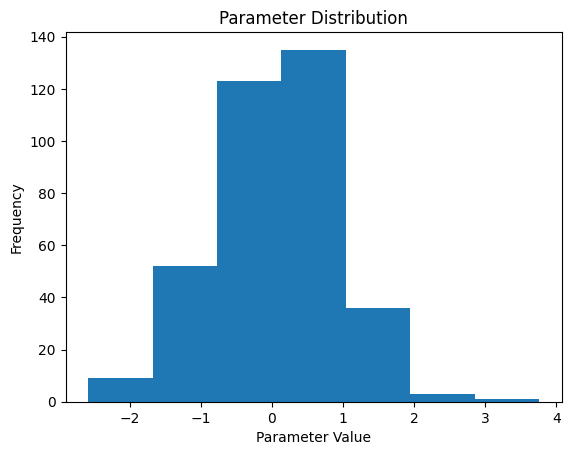

In [ ]:
# TODO: plot the histogram
import numpy as np

# Obtain the parameter values from the trained model
parameters = []
for param in model.parameters():
    parameters.extend(param.flatten().detach().numpy())
parameters = np.array(parameters)

# Plot the histogram
plt.hist(parameters, bins=7)
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.title('Parameter Distribution')
plt.show()

## Final checklist
1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send us notebooks with errors or cells that are not working.*
3. Upload the completed notebook **one week before the exam date of your choice** on the Google Classrom page.

### References

[1] Apicella, A., Donnarumma, F., Isgrò, F. and Prevete, R., 2021. [A survey on modern trainable activation functions](https://arxiv.org/abs/2005.00817).

[2] Jin, X., Xu, C., Feng, J., Wei, Y., Xiong, J. and Yan, S., 2016. [Deep learning with s-shaped rectified linear activation units](https://arxiv.org/abs/1512.07030). In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 30, No. 1).